In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from strategy_tester import Backtesting
from model_loader import ModelLoader
from sklearn.metrics import classification_report

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def trend_changes_score(y_true: np.array, y_pred: np.array) -> str:
    """
    Calcula el reporte de clasificación para los cambios de tendencia.
    """
    y_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    y_df["y_true_shifted"] = y_df["y_true"].shift(-1)
    y_df["is_changed_trend_true"] = y_df["y_true"] != y_df["y_true_shifted"]
    y_df["y_pred_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_pred"] = y_df["y_pred"] != y_df["y_pred_shifted"]
    
    # Se elimina la última fila que tendrá NaN
    y_df = y_df.dropna()
    
    return classification_report(
        y_df["is_changed_trend_true"], 
        y_df["is_changed_trend_pred"], 
        digits=4,
        zero_division=0
    )

SELECCIÓN DEL MEJOR MODELO PRE-ENTRENADO

In [3]:
# Leer el archivo de métricas
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')

# Encontrar el modelo con el mayor trend_change_f1_score
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")

# Construir la ruta del archivo del modelo
model_file = f'../../score_models/{best_model_name}.txt'

# Instanciar y cargar el modelo
loader = ModelLoader(best_model_name, model_file)
model = loader.load()
params = model.params


Mejor modelo según trend_change_f1_score: LightGBM


CARGA Y PREPARACIÓN DE DATOS

In [4]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])

# --- Limitar el test set para pruebas rápidas ---
# Para pruebas rápidas, puedes limitar el número de días. Para un backtest completo, usa todos los datos.
# n_days_to_test = 50 
# test_set = test_set_full.head(n_days_to_test).copy()

# Preparar los arrays de numpy para la clase Backtesting
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

Ejecución del Backtesting con Walk-Forward Optimization

In [5]:
# 1. Configuración de parámetros del backtesting
initial_capital = 10000.0 # Capital inicial para la simulación
window_size = 5 # Número de días en cada ventana de prueba antes de re-optimizar.
optuna_trials_initial_step = 700 # Número de trials de Optuna en el primer paso (más intensivo).
optuna_trials_per_step = 200 # Número de trials para los pasos de re-optimización siguientes.

# 2. Instanciar la clase Backtesting con los datos y la configuración.
# La clase se encarga de todo el proceso de Walk-Forward Optimization
bt = Backtesting(
    best_model_name, # Se pasa el nombre del modelo a usar.
    X_train, y_train, X_val, y_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials_initial=optuna_trials_initial_step,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método que contiene toda la lógica del backtesting
# Devuelve el historial de la cartera y métricas clave de la simulación.
backtest_df, price_col, num_buys, num_sells, winning_trades, losing_trades, total_gains, total_losses = bt.run()

# 3. Cálculo de los resultados finales de la estrategia principal.
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100


[I 2025-09-06 18:31:54,197] Trial 58 finished with value: 0.39436619718309857 and parameters: {'learning_rate': 0.025106815995426985, 'num_leaves': 100, 'max_depth': 4, 'feature_fraction': 0.6210240357989735, 'bagging_fraction': 0.6171799882195853, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 45 with value: 0.42424242424242425.
[I 2025-09-06 18:31:54,724] Trial 59 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.02130021949652199, 'num_leaves': 43, 'max_depth': 5, 'feature_fraction': 0.8224667129965111, 'bagging_fraction': 0.6492602090095068, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 45 with value: 0.42424242424242425.
[I 2025-09-06 18:31:55,146] Trial 60 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.051638730079102614, 'num_leaves': 82, 'max_depth': 9, 'feature_fraction': 0.9802840842677923, 'bagging_fraction': 0.8784289993836386, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 45 with 

  -> Fin de la ventana (días 80-84). Valor del Portafolio: $11,339.77
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-06 18:33:58,819] Trial 0 finished with value: 0.4411764705882353 and parameters: {'learning_rate': 0.010936603478197948, 'num_leaves': 30, 'max_depth': 10, 'feature_fraction': 0.6860889587394403, 'bagging_fraction': 0.9817372302570179, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 0 with value: 0.4411764705882353.
[I 2025-09-06 18:34:00,246] Trial 1 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4411764705882353.
[I 2025-09-06 18:34:00,607] Trial 2 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 85-89). Valor del Portafolio: $11,095.20
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:35:25,041] Trial 1 finished with value: 0.3880597014925373 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.42424242424242425.
[I 2025-09-06 18:35:25,428] Trial 2 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.42424242424242425.
[I 2025-09-06 18:35:26,210] Trial 3 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 90-94). Valor del Portafolio: $11,799.63
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:36:25,130] Trial 0 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.15215971063709377, 'num_leaves': 42, 'max_depth': 4, 'feature_fraction': 0.8037207619665403, 'bagging_fraction': 0.9339135842414236, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-06 18:36:26,371] Trial 1 finished with value: 0.3389830508474576 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-06 18:36:26,836] Trial 2 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 

  -> Fin de la ventana (días 95-99). Valor del Portafolio: $13,365.00
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:37:33,411] Trial 0 finished with value: 0.4225352112676056 and parameters: {'learning_rate': 0.07957631787061872, 'num_leaves': 57, 'max_depth': 9, 'feature_fraction': 0.8977685858839197, 'bagging_fraction': 0.7127105690670921, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:37:34,538] Trial 1 finished with value: 0.3389830508474576 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:37:35,010] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4225352112676056.

  -> Fin de la ventana (días 100-104). Valor del Portafolio: $13,842.81
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:38:44,987] Trial 0 finished with value: 0.375 and parameters: {'learning_rate': 0.0648268343384103, 'num_leaves': 30, 'max_depth': 5, 'feature_fraction': 0.8144574712296591, 'bagging_fraction': 0.775410336477281, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 0 with value: 0.375.
[I 2025-09-06 18:38:46,123] Trial 1 finished with value: 0.3 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.375.
[I 2025-09-06 18:38:46,473] Trial 2 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.375.
[I 2025-09-06 18:38:47,122] Trial 3 finished with val

  -> Fin de la ventana (días 105-109). Valor del Portafolio: $13,655.39
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:41:32,108] Trial 0 finished with value: 0.41935483870967744 and parameters: {'learning_rate': 0.02157662073043901, 'num_leaves': 39, 'max_depth': 5, 'feature_fraction': 0.6530549292232031, 'bagging_fraction': 0.9882512861284954, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-06 18:41:33,091] Trial 1 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-06 18:41:33,464] Trial 2 finished with value: 0.3448275862068966 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 110-114). Valor del Portafolio: $14,154.27
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-06 18:43:40,388] Trial 0 finished with value: 0.41935483870967744 and parameters: {'learning_rate': 0.02903094242575821, 'num_leaves': 22, 'max_depth': 4, 'feature_fraction': 0.6528454742979576, 'bagging_fraction': 0.950377474361542, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-06 18:43:41,422] Trial 1 finished with value: 0.2545454545454545 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-06 18:43:41,787] Trial 2 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 115-119). Valor del Portafolio: $14,432.88
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 5


[I 2025-09-06 18:44:35,115] Trial 1 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4.
[I 2025-09-06 18:44:35,513] Trial 2 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4.
[I 2025-09-06 18:44:36,091] Trial 3 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.4.
[I 2025-09-06 18:44:36,901]

  -> Fin de la ventana (días 120-124). Valor del Portafolio: $14,380.39
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 5


[I 2025-09-06 18:45:34,766] Trial 1 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.34285714285714286.
[I 2025-09-06 18:45:35,199] Trial 2 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.3888888888888889.
[I 2025-09-06 18:45:35,751] Trial 3 finished with value: 0.4117647058823529 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 0

  -> Fin de la ventana (días 125-129). Valor del Portafolio: $15,552.19
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 5


[I 2025-09-06 18:47:06,738] Trial 0 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.022276156017601564, 'num_leaves': 89, 'max_depth': 4, 'feature_fraction': 0.8918359643034046, 'bagging_fraction': 0.7223284990009, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 18:47:08,922] Trial 1 finished with value: 0.24242424242424243 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 18:47:09,289] Trial 2 finished with value: 0.3384615384615385 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.405

  -> Fin de la ventana (días 130-134). Valor del Portafolio: $14,509.74
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 6


[I 2025-09-06 18:48:12,495] Trial 1 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:48:12,995] Trial 2 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:48:13,549] Trial 3 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 135-139). Valor del Portafolio: $14,509.74
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 6


[I 2025-09-06 18:49:04,924] Trial 1 finished with value: 0.23880597014925373 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.40540540540540543.
[I 2025-09-06 18:49:05,505] Trial 2 finished with value: 0.3076923076923077 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.40540540540540543.
[I 2025-09-06 18:49:06,109] Trial 3 finished with value: 0.40540540540540543 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value:

  -> Fin de la ventana (días 140-144). Valor del Portafolio: $14,509.74
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 6


[I 2025-09-06 18:50:05,880] Trial 0 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.11687544349153903, 'num_leaves': 60, 'max_depth': 12, 'feature_fraction': 0.7843982548729594, 'bagging_fraction': 0.9050293018189735, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 0 with value: 0.3582089552238806.
[I 2025-09-06 18:50:07,246] Trial 1 finished with value: 0.31746031746031744 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3582089552238806.
[I 2025-09-06 18:50:07,619] Trial 2 finished with value: 0.36619718309859156 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0

  -> Fin de la ventana (días 145-149). Valor del Portafolio: $14,694.61
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 6


[I 2025-09-06 18:51:33,900] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-06 18:51:34,342] Trial 2 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-06 18:51:34,902] Trial 3 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 0

  -> Fin de la ventana (días 150-154). Valor del Portafolio: $13,846.63
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-06 18:52:26,042] Trial 0 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.05461420166249284, 'num_leaves': 21, 'max_depth': 4, 'feature_fraction': 0.6260759311336229, 'bagging_fraction': 0.7065171630545946, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 0 with value: 0.42105263157894735.
[I 2025-09-06 18:52:27,007] Trial 1 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.42105263157894735.
[I 2025-09-06 18:52:27,359] Trial 2 finished with value: 0.3466666666666667 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 155-159). Valor del Portafolio: $13,846.63
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 7


[I 2025-09-06 18:53:27,965] Trial 0 finished with value: 0.410958904109589 and parameters: {'learning_rate': 0.05189429889427859, 'num_leaves': 76, 'max_depth': 11, 'feature_fraction': 0.7486227209707547, 'bagging_fraction': 0.8185647615494736, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 0 with value: 0.410958904109589.
[I 2025-09-06 18:53:29,049] Trial 1 finished with value: 0.4383561643835616 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.4383561643835616.
[I 2025-09-06 18:53:29,425] Trial 2 finished with value: 0.39473684210526316 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.43

  -> Fin de la ventana (días 160-164). Valor del Portafolio: $14,530.74
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 7


[I 2025-09-06 18:54:19,805] Trial 1 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.44155844155844154.
[I 2025-09-06 18:54:20,210] Trial 2 finished with value: 0.40540540540540543 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.44155844155844154.
[I 2025-09-06 18:54:20,693] Trial 3 finished with value: 0.410958904109589 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 165-169). Valor del Portafolio: $15,038.22
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 7


[I 2025-09-06 18:55:09,498] Trial 1 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 18:55:09,937] Trial 2 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 18:55:10,566] Trial 3 finished with value: 0.43478260869565216 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 0

  -> Fin de la ventana (días 170-174). Valor del Portafolio: $14,531.31
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-06 18:56:28,714] Trial 1 finished with value: 0.37333333333333335 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4155844155844156.
[I 2025-09-06 18:56:29,259] Trial 2 finished with value: 0.4146341463414634 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4155844155844156.
[I 2025-09-06 18:56:29,792] Trial 3 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 175-179). Valor del Portafolio: $14,531.31
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-06 18:57:23,336] Trial 0 finished with value: 0.4533333333333333 and parameters: {'learning_rate': 0.04615485047299664, 'num_leaves': 29, 'max_depth': 8, 'feature_fraction': 0.9678804159456051, 'bagging_fraction': 0.7743416434350942, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 0 with value: 0.4533333333333333.
[I 2025-09-06 18:57:24,797] Trial 1 finished with value: 0.4155844155844156 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4533333333333333.
[I 2025-09-06 18:57:25,229] Trial 2 finished with value: 0.4266666666666667 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.45

  -> Fin de la ventana (días 180-184). Valor del Portafolio: $14,531.31
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-06 18:58:26,688] Trial 1 finished with value: 0.410958904109589 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 18:58:27,158] Trial 2 finished with value: 0.3950617283950617 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 18:58:27,831] Trial 3 finished with value: 0.4166666666666667 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.43

  -> Fin de la ventana (días 185-189). Valor del Portafolio: $14,531.31
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-06 18:59:17,589] Trial 1 finished with value: 0.3835616438356164 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:59:18,120] Trial 2 finished with value: 0.40540540540540543 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4225352112676056.
[I 2025-09-06 18:59:18,759] Trial 3 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 190-194). Valor del Portafolio: $14,531.31
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-06 19:00:56,646] Trial 0 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 0.036525757409751856, 'num_leaves': 94, 'max_depth': 9, 'feature_fraction': 0.8311609516923208, 'bagging_fraction': 0.9711935245043471, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 0 with value: 0.35294117647058826.
[I 2025-09-06 19:00:57,706] Trial 1 finished with value: 0.375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.375.
[I 2025-09-06 19:00:58,056] Trial 2 finished with value: 0.3684210526315789 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.375.
[I 2025-09-06 19:00:

  -> Fin de la ventana (días 195-199). Valor del Portafolio: $14,272.03
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:03:23,710] Trial 0 finished with value: 0.44776119402985076 and parameters: {'learning_rate': 0.035393390786382505, 'num_leaves': 27, 'max_depth': 9, 'feature_fraction': 0.753697837541695, 'bagging_fraction': 0.8490341440818766, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 0 with value: 0.44776119402985076.
[I 2025-09-06 19:03:24,829] Trial 1 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.44776119402985076.
[I 2025-09-06 19:03:25,207] Trial 2 finished with value: 0.41025641025641024 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 200-204). Valor del Portafolio: $14,272.03
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:04:54,002] Trial 0 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.023012536271925847, 'num_leaves': 76, 'max_depth': 12, 'feature_fraction': 0.9820559747905796, 'bagging_fraction': 0.9934661293422609, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-06 19:04:55,066] Trial 1 finished with value: 0.36619718309859156 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.36619718309859156.
[I 2025-09-06 19:04:55,632] Trial 2 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with valu

  -> Fin de la ventana (días 205-209). Valor del Portafolio: $14,272.03
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:06:36,145] Trial 0 finished with value: 0.463768115942029 and parameters: {'learning_rate': 0.03439708564286053, 'num_leaves': 39, 'max_depth': 4, 'feature_fraction': 0.9072747961432955, 'bagging_fraction': 0.9710776637313557, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 0 with value: 0.463768115942029.
[I 2025-09-06 19:06:37,319] Trial 1 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.463768115942029.
[I 2025-09-06 19:06:37,668] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.463768115942029.
[I

  -> Fin de la ventana (días 210-214). Valor del Portafolio: $14,272.03
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:08:09,915] Trial 0 finished with value: 0.3835616438356164 and parameters: {'learning_rate': 0.059446475981655686, 'num_leaves': 84, 'max_depth': 5, 'feature_fraction': 0.7830375432992486, 'bagging_fraction': 0.6815978165999009, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 0 with value: 0.3835616438356164.
[I 2025-09-06 19:08:10,951] Trial 1 finished with value: 0.34375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3835616438356164.
[I 2025-09-06 19:08:11,333] Trial 2 finished with value: 0.3835616438356164 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.383561643835

  -> Fin de la ventana (días 215-219). Valor del Portafolio: $14,272.03
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:09:42,412] Trial 0 finished with value: 0.4788732394366197 and parameters: {'learning_rate': 0.09131681976170765, 'num_leaves': 46, 'max_depth': 12, 'feature_fraction': 0.9531164261724281, 'bagging_fraction': 0.9253165472549754, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 0 with value: 0.4788732394366197.
[I 2025-09-06 19:09:46,536] Trial 1 finished with value: 0.34285714285714286 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4788732394366197.
[I 2025-09-06 19:09:46,877] Trial 2 finished with value: 0.37333333333333335 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 220-224). Valor del Portafolio: $14,532.29
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:11:48,057] Trial 0 finished with value: 0.417910447761194 and parameters: {'learning_rate': 0.051552149548357316, 'num_leaves': 95, 'max_depth': 12, 'feature_fraction': 0.984806720806351, 'bagging_fraction': 0.9996888157693207, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 0 with value: 0.417910447761194.
[I 2025-09-06 19:11:49,852] Trial 1 finished with value: 0.3076923076923077 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.417910447761194.
[I 2025-09-06 19:11:50,360] Trial 2 finished with value: 0.35135135135135137 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.417

  -> Fin de la ventana (días 225-229). Valor del Portafolio: $15,079.17
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-06 19:12:51,648] Trial 0 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.1703447068318905, 'num_leaves': 50, 'max_depth': 12, 'feature_fraction': 0.8694456591183515, 'bagging_fraction': 0.8932588779086448, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-06 19:12:52,731] Trial 1 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-06 19:12:53,106] Trial 2 finished with value: 0.43478260869565216 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 

  -> Fin de la ventana (días 230-234). Valor del Portafolio: $14,260.56
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:13:50,090] Trial 0 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.1670897349143489, 'num_leaves': 50, 'max_depth': 7, 'feature_fraction': 0.7831955953681701, 'bagging_fraction': 0.6474712741190336, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 0 with value: 0.3283582089552239.
[I 2025-09-06 19:13:50,720] Trial 1 finished with value: 0.34285714285714286 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.34285714285714286.
[I 2025-09-06 19:13:51,201] Trial 2 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.

  -> Fin de la ventana (días 235-239). Valor del Portafolio: $14,260.56
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:14:39,444] Trial 1 finished with value: 0.3188405797101449 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3870967741935484.
[I 2025-09-06 19:14:39,903] Trial 2 finished with value: 0.3939393939393939 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.3939393939393939.
[I 2025-09-06 19:14:40,349] Trial 3 finished with value: 0.375 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 2 with value: 0.39393939393939

  -> Fin de la ventana (días 240-244). Valor del Portafolio: $14,260.56
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:15:31,906] Trial 1 finished with value: 0.3384615384615385 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4444444444444444.
[I 2025-09-06 19:15:32,332] Trial 2 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4444444444444444.
[I 2025-09-06 19:15:32,765] Trial 3 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.4

  -> Fin de la ventana (días 245-249). Valor del Portafolio: $14,460.17
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:16:27,670] Trial 1 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3880597014925373.
[I 2025-09-06 19:16:28,092] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.3880597014925373.
[I 2025-09-06 19:16:28,482] Trial 3 finished with value: 0.375 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.38805970149253

  -> Fin de la ventana (días 250-254). Valor del Portafolio: $14,543.15
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:17:54,174] Trial 0 finished with value: 0.4383561643835616 and parameters: {'learning_rate': 0.02710987303924608, 'num_leaves': 82, 'max_depth': 8, 'feature_fraction': 0.9908969624228187, 'bagging_fraction': 0.8114038310723788, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 19:17:55,263] Trial 1 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 19:17:55,664] Trial 2 finished with value: 0.375 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.43835616438356

  -> Fin de la ventana (días 255-259). Valor del Portafolio: $16,065.12
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:18:57,630] Trial 0 finished with value: 0.3939393939393939 and parameters: {'learning_rate': 0.030572060938093757, 'num_leaves': 63, 'max_depth': 6, 'feature_fraction': 0.7782435140934633, 'bagging_fraction': 0.7956823080833269, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 0 with value: 0.3939393939393939.
[I 2025-09-06 19:18:58,708] Trial 1 finished with value: 0.29411764705882354 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3939393939393939.
[I 2025-09-06 19:18:59,070] Trial 2 finished with value: 0.36619718309859156 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 260-264). Valor del Portafolio: $16,112.36
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:19:49,550] Trial 0 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.06753609985039019, 'num_leaves': 86, 'max_depth': 5, 'feature_fraction': 0.9392002360379132, 'bagging_fraction': 0.6261691903577457, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 0 with value: 0.37142857142857144.
[I 2025-09-06 19:19:50,754] Trial 1 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.37142857142857144.
[I 2025-09-06 19:19:51,111] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 265-269). Valor del Portafolio: $16,115.92
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:20:57,466] Trial 0 finished with value: 0.4 and parameters: {'learning_rate': 0.036533514991796134, 'num_leaves': 70, 'max_depth': 7, 'feature_fraction': 0.9893684643123051, 'bagging_fraction': 0.7491190288449655, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 0 with value: 0.4.
[I 2025-09-06 19:20:58,888] Trial 1 finished with value: 0.3235294117647059 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4.
[I 2025-09-06 19:20:59,271] Trial 2 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4.
[I 2025-09-06 19:20:59,720] Trial 3 finish

  -> Fin de la ventana (días 270-274). Valor del Portafolio: $17,602.14
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:22:00,210] Trial 0 finished with value: 0.3880597014925373 and parameters: {'learning_rate': 0.05837124545270808, 'num_leaves': 41, 'max_depth': 5, 'feature_fraction': 0.9962620848340337, 'bagging_fraction': 0.8068270330055538, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 0 with value: 0.3880597014925373.
[I 2025-09-06 19:22:01,419] Trial 1 finished with value: 0.3384615384615385 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3880597014925373.
[I 2025-09-06 19:22:01,857] Trial 2 finished with value: 0.375 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.388059701492537

  -> Fin de la ventana (días 275-279). Valor del Portafolio: $17,693.74
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:23:11,427] Trial 0 finished with value: 0.4383561643835616 and parameters: {'learning_rate': 0.0444756154653587, 'num_leaves': 49, 'max_depth': 12, 'feature_fraction': 0.9041418304713559, 'bagging_fraction': 0.9737357869792826, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 19:23:12,437] Trial 1 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4383561643835616.
[I 2025-09-06 19:23:12,904] Trial 2 finished with value: 0.38095238095238093 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 280-284). Valor del Portafolio: $18,046.89
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:24:08,057] Trial 1 finished with value: 0.375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 19:24:08,537] Trial 2 finished with value: 0.39344262295081966 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-06 19:24:08,942] Trial 3 finished with value: 0.3793103448275862 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.4057971014492

  -> Fin de la ventana (días 285-289). Valor del Portafolio: $18,420.93
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


[I 2025-09-06 19:24:55,347] Trial 0 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.06794169919058383, 'num_leaves': 90, 'max_depth': 11, 'feature_fraction': 0.9690581491033856, 'bagging_fraction': 0.8251665642216157, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 0 with value: 0.36923076923076925.
[I 2025-09-06 19:24:56,641] Trial 1 finished with value: 0.3880597014925373 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.3880597014925373.
[I 2025-09-06 19:24:56,965] Trial 2 finished with value: 0.38095238095238093 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 

  -> Fin de la ventana (días 290-294). Valor del Portafolio: $18,049.62
  -> Compras ejecutadas: 11
  -> Ventas ejecutadas: 10


In [6]:
# Calcular el retorno de la estrategia de referencia "Buy & Hold".
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

# --- Calcular la estrategia Dollar Cost Averaging (DCA) en 12 plazos fijos ---
print("\n--- Calculando la estrategia DCA (12 inversiones en el período) ---")

# 1. Definir el monto por inversión y el intervalo
num_investments = 12
investment_amount = initial_capital / num_investments
num_days_in_backtest = len(backtest_df)
# Se invierte cada 'investment_interval' días. Usamos // para obtener un número entero.
investment_interval = num_days_in_backtest // num_investments

dca_portfolio_values = []
total_btc_owned = 0.0
investments_made = 0

# 2. Iterar a través de los días del backtest usando un contador de días (idx)
for idx, (df_index, row) in enumerate(backtest_df.iterrows()):
    current_date = row['date']
    current_price = row[price_col]

    # 3. Invertir si el día actual es un múltiplo del intervalo de inversión
    # Esto asegura que se invierta al principio y luego a intervalos regulares.
    if idx % investment_interval == 0 and investments_made < num_investments:
        btc_bought = investment_amount / current_price
        total_btc_owned += btc_bought
        investments_made += 1
        print(f"  -> DCA ({investments_made}/{num_investments}): Invirtiendo ${investment_amount:,.2f} el {current_date.strftime('%Y-%m-%d')}")

    # 4. Calcular el valor del portafolio para CADA día
    portfolio_value = total_btc_owned * current_price
    dca_portfolio_values.append(portfolio_value)

# Añadir los resultados al DataFrame para facilitar el ploteo
backtest_df['dca_portfolio_value'] = dca_portfolio_values

# Calcular y guardar el valor final y el retorno de DCA ---
dca_final_value = dca_portfolio_values[-1]
dca_return_pct = (dca_final_value - initial_capital) / initial_capital * 100

print(f"\nSe realizaron {investments_made} inversiones de DCA en total.")
print(f"Valor final del portafolio DCA: ${dca_final_value:,.2f}")


--- Calculando la estrategia DCA (12 inversiones en el período) ---
  -> DCA (1/12): Invirtiendo $833.33 el 2024-08-09
  -> DCA (2/12): Invirtiendo $833.33 el 2024-09-02
  -> DCA (3/12): Invirtiendo $833.33 el 2024-09-26
  -> DCA (4/12): Invirtiendo $833.33 el 2024-10-20
  -> DCA (5/12): Invirtiendo $833.33 el 2024-11-13
  -> DCA (6/12): Invirtiendo $833.33 el 2024-12-07
  -> DCA (7/12): Invirtiendo $833.33 el 2024-12-31
  -> DCA (8/12): Invirtiendo $833.33 el 2025-01-24
  -> DCA (9/12): Invirtiendo $833.33 el 2025-02-17
  -> DCA (10/12): Invirtiendo $833.33 el 2025-03-13
  -> DCA (11/12): Invirtiendo $833.33 el 2025-04-06
  -> DCA (12/12): Invirtiendo $833.33 el 2025-04-30

Se realizaron 12 inversiones de DCA en total.
Valor final del portafolio DCA: $13,273.72


In [7]:
print("\n--- Resultados del Backtesting (Walk-Forward Optimization) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")
print(f"Retorno de Dollar Cost Averaging (DCA): {dca_return_pct:.2f}%")


--- Resultados del Backtesting (Walk-Forward Optimization) ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $18,049.62
Retorno Total de la Estrategia: 80.50%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%
Retorno de Dollar Cost Averaging (DCA): 32.74%


In [8]:
# 4. Análisis de Operaciones

print("\n--- Análisis de Operaciones Reales ---")
print(f"Número de COMPRAS ejecutadas: {num_buys}")
print(f"Número de VENTAS ejecutadas: {num_sells}")
print(f"Número total de transacciones: {num_buys + num_sells}")


--- Análisis de Operaciones Reales ---
Número de COMPRAS ejecutadas: 11
Número de VENTAS ejecutadas: 10
Número total de transacciones: 21


In [9]:
# --- Análisis de Rentabilidad por Operación ---
print("\n--- Análisis de Rentabilidad por Operación ---")
total_closed_trades = winning_trades + losing_trades
if total_closed_trades > 0:
    win_rate = (winning_trades / total_closed_trades) * 100
    # El Profit Factor es una métrica clave: Ganancias Totales / Pérdidas Totales
    profit_factor = total_gains / total_losses if total_losses > 0 else float('inf')
    
    print(f"Número de operaciones ganadoras: {winning_trades}")
    print(f"Número de operaciones perdedoras: {losing_trades}")
    print(f"Número total de operaciones cerradas: {total_closed_trades}")
    print(f"Tasa de acierto (Win Rate): {win_rate:.2f}%")
    print("-" * 20)
    print(f"Ganancia total de operaciones ganadoras: ${total_gains:,.2f}")
    print(f"Pérdida total de operaciones perdedoras: ${total_losses:,.2f}")
    print(f"Profit Factor (Ganancias/Pérdidas): {profit_factor:.2f}")
else:
    print("No se completaron ciclos de compra-venta en el backtest.")


--- Análisis de Rentabilidad por Operación ---
Número de operaciones ganadoras: 5
Número de operaciones perdedoras: 5
Número total de operaciones cerradas: 10
Tasa de acierto (Win Rate): 50.00%
--------------------
Ganancia total de operaciones ganadoras: $5,834.26
Pérdida total de operaciones perdedoras: $1,573.71
Profit Factor (Ganancias/Pérdidas): 3.71


In [10]:
# 5. Métricas de Clasificación sobre todo el Backtest

# Extraer las predicciones y los valores reales del período de backtesting
y_pred_backtest = backtest_df['signal'].values
y_true_backtest = test_set.loc[backtest_df.index, 'target_trend'].values

print("\n--- Métricas de Clasificación del Backtest Completo ---")

# Reporte de clasificación estándar (predicción de tendencia -1, 0, 1)
print("\nReporte de Clasificación (Tendencia):")
print(classification_report(y_true_backtest, y_pred_backtest, digits=4, zero_division=0))

# Reporte de clasificación de cambio de tendencia (predicción de True/False)
print("\nReporte de Cambio de Tendencia:")
print(trend_changes_score(y_true_backtest, y_pred_backtest))


--- Métricas de Clasificación del Backtest Completo ---

Reporte de Clasificación (Tendencia):
              precision    recall  f1-score   support

          -1     0.8559    0.9794    0.9135        97
           0     0.5000    0.1538    0.2353        26
           1     0.9432    0.9651    0.9540       172

    accuracy                         0.8983       295
   macro avg     0.7663    0.6994    0.7009       295
weighted avg     0.8754    0.8983    0.8773       295


Reporte de Cambio de Tendencia:
              precision    recall  f1-score   support

       False     0.9361    0.9468    0.9414       263
        True     0.5000    0.4516    0.4746        31

    accuracy                         0.8946       294
   macro avg     0.7180    0.6992    0.7080       294
weighted avg     0.8901    0.8946    0.8922       294



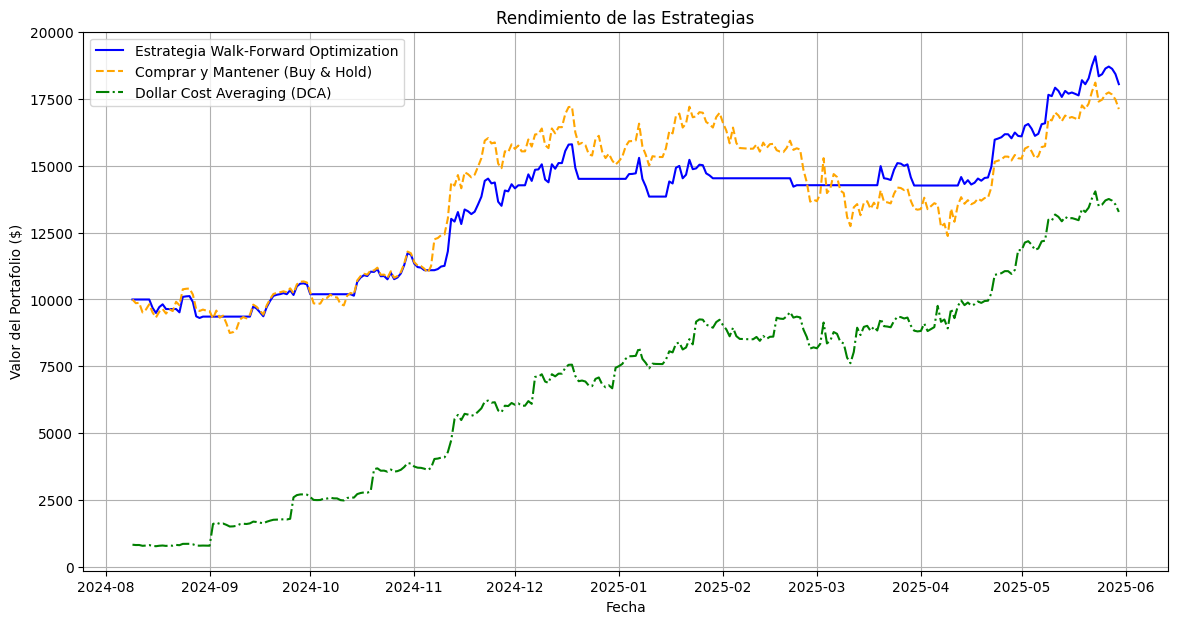

In [11]:
# 6. Visualización
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia Walk-Forward Optimization', color='blue')

# Calcular la curva de Buy & Hold para la visualización
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

# Añadir la curva de DCA al gráfico ---
plt.plot(backtest_df['date'], backtest_df['dca_portfolio_value'], label='Dollar Cost Averaging (DCA)', color='green', linestyle='-.')


plt.title('Rendimiento de las Estrategias')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()